In [1]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
train= pd.read_csv("C:/Users/happy/Desktop/Strathclyde academic/Sem 2/CS986/Assignment/Score/CS98XRegressionTrain.csv",low_memory=False)
test= pd.read_csv("C:/Users/happy/Desktop/Strathclyde academic/Sem 2/CS986/Assignment/Score/CS98XRegressionTest.csv",low_memory=False)
spot_1950 = pd.read_csv("C:/Users/happy/Desktop/Strathclyde academic/Sem 2/CS986/Assignment/Data/1950.csv",low_memory=False)
spot_1960 = pd.read_csv("C:/Users/happy/Desktop/Strathclyde academic/Sem 2/CS986/Assignment/Data/1960.csv",low_memory=False)
spot_1970 = pd.read_csv("C:/Users/happy/Desktop/Strathclyde academic/Sem 2/CS986/Assignment/Data/1970.csv",low_memory=False)
spot_1980 = pd.read_csv("C:/Users/happy/Desktop/Strathclyde academic/Sem 2/CS986/Assignment/Data/1980.csv",low_memory=False)
spot_1990 = pd.read_csv("C:/Users/happy/Desktop/Strathclyde academic/Sem 2/CS986/Assignment/Data/1990.csv",low_memory=False)
spot_2000 = pd.read_csv("C:/Users/happy/Desktop/Strathclyde academic/Sem 2/CS986/Assignment/Data/2000.csv",low_memory=False)
spot_2010 = pd.read_csv("C:/Users/happy/Desktop/Strathclyde academic/Sem 2/CS986/Assignment/Data/2010.csv",low_memory=False)

In [3]:
# Combine train and test set for correlation calculation
frames = [spot_1950, spot_1960, spot_1970, spot_1980, spot_1990, spot_2000, spot_2010]
combine_spot = pd.concat(frames)

In [4]:
combine_spot = combine_spot.drop('Number', axis =1)

In [5]:
combine_spot = combine_spot.corr()
combine_spot.style.background_gradient(cmap='coolwarm')

,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
year,1.000000,-0.020790,0.195329,0.273865,0.422602,-0.001603,-0.087055,-0.099655,-0.241289,0.193292,0.160467
bpm,-0.020790,1.000000,0.179329,-0.057710,0.044748,0.009960,0.084723,0.038277,-0.175530,0.059116,0.066558
nrgy,0.195329,0.179329,1.000000,0.331962,0.702543,0.132563,0.405190,0.131228,-0.665900,0.178491,0.271798
dnce,0.273865,-0.057710,0.331962,1.000000,0.295534,-0.069818,0.454714,0.053011,-0.382297,0.207741,0.249302
dB,0.422602,0.044748,0.702543,0.295534,1.000000,0.083423,0.136813,0.026851,-0.504551,0.200195,0.365172
live,-0.001603,0.009960,0.132563,-0.069818,0.083423,1.000000,0.060542,-0.067533,-0.056394,0.091595,-0.036505
val,-0.087055,0.084723,0.405190,0.454714,0.136813,0.060542,1.000000,-0.118664,-0.196375,0.053817,-0.102418
dur,-0.099655,0.038277,0.131228,0.053011,0.026851,-0.067533,-0.118664,1.000000,-0.227505,0.045265,0.280501
acous,-0.241289,-0.175530,-0.665900,-0.382297,-0.504551,-0.056394,-0.196375,-0.227505,1.000000,-0.172820,-0.455239
spch,0.193292,0.059116,0.178491,0.207741,0.200195,0.091595,0.053817,0.045265,-0.172820,1.000000,0.192929


In [6]:
sample_nas = train[train.isnull().any(axis=1)].head()

In [7]:
#drop rows with missing values and replace NA in test as 'adult standard'
train = train.dropna()

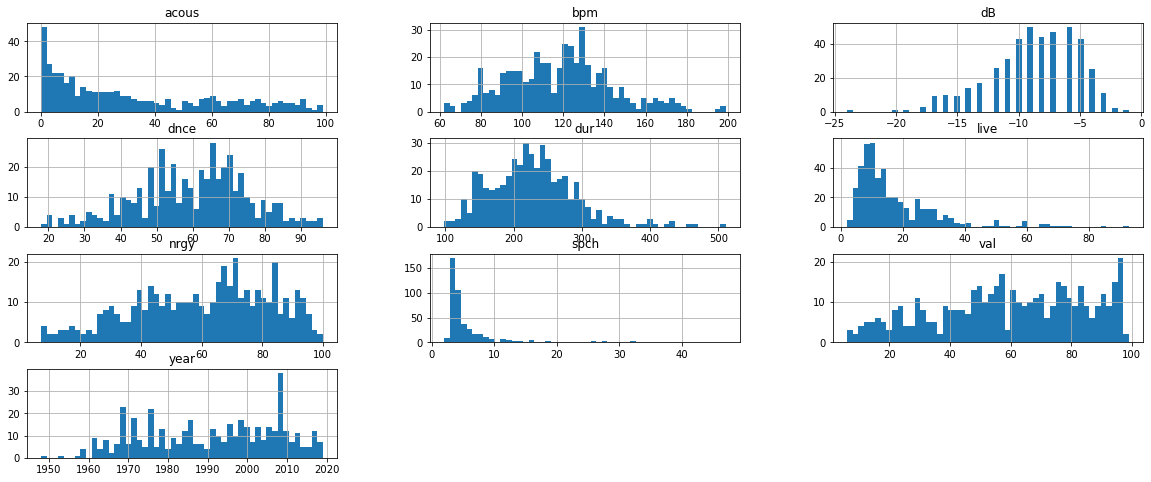

In [8]:
# Plot histogram to check the distrbution of the data of each variable and compare it with the test data.
# We would like to verify that the distribution of both sets are similar so that the learning from the train set can be applied to the test set.   
%matplotlib inline
train.drop(['Id','pop'],axis=1).hist(bins=50, figsize=(20,8))
plt.show()

In [ ]:
%matplotlib inline
test.drop(['Id'],axis=1).hist(bins=50, figsize=(20,8))
plt.show()
#test and train sets have similar distribution

In [9]:
# Define X and Y in train to seperate the dependent and independent variables to build the model and upload predictions
X_train = train.iloc[:,2:14] # Remove Id and title column
Y_train = train.iloc[:,14:]

In [10]:
# Drop artist in train because the data is sparse and have no influence in improving our test predictions
X_train= X_train.drop(['artist'],axis=1)

In [11]:
# rename top genre
X_train.rename(columns={'top genre':'top_genre'}, inplace=True)
test.rename(columns={'top genre':'top_genre'}, inplace=True)

In [12]:
# One-Hot top_genre
# We decided to use one-hot encoding for categorical data as some machine learning algorithms require all the data to be numeric.
# Since top_genre is categorical, we will encode this with one hot encoding over integer-encoding because there is no ordial relationship with the data. 
train_top_genre = X_train['top_genre']
genre_cat_encoded, genre_cat_name = train_top_genre.factorize()
#Train encoder
top_genreenc = OneHotEncoder(handle_unknown = 'ignore')
top_genreenc.fit(genre_cat_encoded.reshape(-1,1))
#Transform data
top_genre_enc_data = pd.DataFrame(top_genreenc.transform(genre_cat_encoded.reshape(-1,1)).toarray())
top_genre_enc_data.columns = genre_cat_name
top_genre_enc_data.index = X_train.index

In [13]:
# Separate categorical and numerical attributes so that we can scale the numerical variables for our SVM models. 
# Scaling is not performed in decision trees and random forest because they do not use distance measures.
cat_attribs = ['top_genre']
X_train_num = X_train.drop(cat_attribs, axis=1)
num_attribs = list(X_train_num)

In [14]:
#Merged categorical and numerical data together in order to produce the final complete train data.
X_train_prepared = X_train_num.join(top_genre_enc_data)

In [15]:
# Checked for NA values in test set as they would prohibit the model from running. 
X_test = test.iloc[:,2:14] # Remove Id and title column
X_test[X_test.isnull().any(axis=1)].head()

,artist,top_genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch
66,U.S.A. For Africa,NaN,1985,73,45,53,-15,7,29,427,19,4


In [16]:
# We checked for the top_genre with the highest frequency and would replace NA with the one appears most.
train["top genre"].value_counts()

adult standards       68
album rock            66
dance pop             61
brill building pop    16
glam rock             16
                      ..
country                1
italian pop            1
alternative rock       1
yodeling               1
acoustic blues         1
Name: top genre, Length: 86, dtype: int64

In [17]:
# Replace the NA from index 66 in test set as'adult standards' because it appears the most in the train set.
# By replacing the NA, instead of removing the observation, we reserved the total number of rows which allowed Kaggle to evaluate our predictions
X_test.iloc[66,1] = 'adult standards'
X_test.iloc[66,:] 

artist       U.S.A. For Africa
top_genre      adult standards
year                      1985
bpm                         73
nrgy                        45
dnce                        53
dB                         -15
live                         7
val                         29
dur                        427
acous                       19
spch                         4
Name: 66, dtype: object

In [18]:
# Since the artist column has been dropped from the train set, we perform the same step in the test set.
X_test= X_test.drop(['artist'],axis=1)

In [19]:
#Transform top_genre in test data
test_top_genre = pd.DataFrame(X_test['top_genre'])
# We use the encoder trained on train set to transform the test set
test_top_genre_enc_data = pd.DataFrame(top_genreenc.transform(test_top_genre).toarray())
test_top_genre_enc_data.columns = genre_cat_name
test_top_genre_enc_data.index = X_test.index

In [20]:
# We seperated the numerical variables in the train set to scale them for SVM models. This same step is done for the test set.
X_test_num = X_test.drop(cat_attribs, axis=1)
X_test_prepared = X_test_num.join(test_top_genre_enc_data)

In [21]:
# Multicollinearity between variables could negatively impact the final model. It is important to remove dependent variables with a weak relationship with the independent varaible and other variables which are highly correlated with each other. Drop dB and nrgy because they are highly correlated with each other.
X_train_prepared= X_train_prepared.drop(['dB','nrgy','live','bpm'],axis=1)
X_test_prepared= X_test_prepared.drop(['dB','nrgy','live','bpm'],axis=1)

In [22]:
# We decided to use the decision tree because it yields the lowest RMSE score on the test set, compared with the SVM model. It is also easier to visualize and quantify a decision tree with fewer number of tuning hyperparameter.

In [23]:
# Calculate the RMSE and accuracy score for train set. This helps us determine the starting point of testing the depth of the tree
from sklearn.metrics import r2_score, mean_squared_error
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor 
train_RMSE= []
train_acc= []
for depth in range(1,26):
    tree_reg = DecisionTreeRegressor(max_depth=depth,random_state=0)
    tree_reg.fit(X_train_prepared, Y_train)
    pred_train=tree_reg.predict(X_train_prepared)   
    train_acc.append(tree_reg.score(X_train_prepared, Y_train))
    train_RMSE.append(np.sqrt(metrics.mean_absolute_error(Y_train, pred_train)))

In [24]:
# Build a table with RMSE and accuracy score for train set
train_RMSE_acc_table= pd.DataFrame({'max_depth':range(1,26), 'train_RMSE':train_RMSE, 'train_acc':train_acc})

Text(0, 0.5, 'performance')

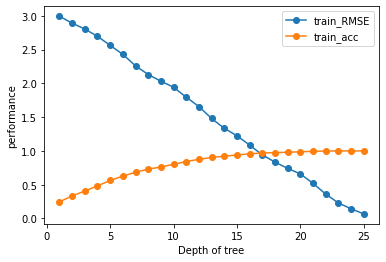

In [25]:
# Plot RMSE and accuracy score for train set
# The RMSE decreases at an equal constant rate as the depth size increases. 
# The accuracy score starts to level off after depth= 8, so we started by training the model with it and decreased the depth to test different results
train_RMSE_acc_table.plot('max_depth', y=['train_RMSE','train_acc'],kind='line',marker='o')
plt.xlabel('Depth of tree')
plt.ylabel('performance')

In [26]:
# We assigned different max_depths to the decision tree regression in to produce the best model. We finally fixed the max_depth=2. 
from sklearn.tree import DecisionTreeRegressor 
tree_reg = DecisionTreeRegressor(max_depth=2,random_state=0) # random_state set to 0 to keep output constant
tree_reg.fit(X_train_prepared, Y_train)

DecisionTreeRegressor(max_depth=2, random_state=0)

In [27]:
# Train predictions
pred_train=tree_reg.predict(X_train_prepared)

In [28]:
# Test predictions
pred = pd.DataFrame(tree_reg.predict(X_test_prepared))

In [29]:
# Print RMSE score for train set with max_dept=2
train_RMSE_dp2= np.sqrt(metrics.mean_absolute_error(Y_train, pred_train))
train_RMSE_dp2

2.8904381785882425

In [30]:
# Specify column names for plotting tree
fn = X_train_prepared.columns
tn = Y_train.columns

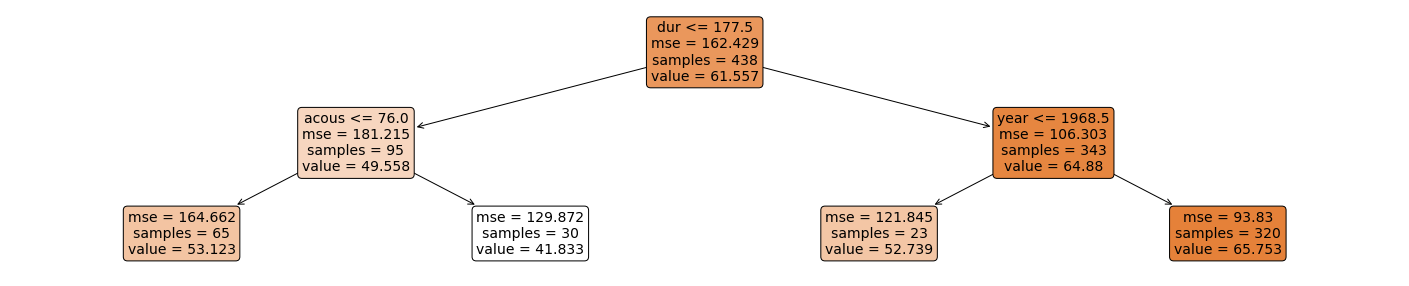

In [31]:
#  Produce a decision tree to assess the performance of the model and get an indication if more regularisation is required.
from sklearn.tree import plot_tree
plt.figure(figsize=(25,5))
tree = plot_tree(tree_reg, feature_names=fn, class_names=tn, filled=True, rounded=True, fontsize=14)

In [32]:
# Prepare predictions to submit
pred.columns = ['pop'] #Rename the prediction column
test_ids = pd.DataFrame(test['Id']) #Get ids from the test data
pred = test_ids.join(pred) #Merge predictions to ids
pred.reset_index(drop=True, inplace=True) #Remove index from the dataframe because Kaggle expects only 2 columns, ids and pop

In [33]:
# Export data to csv for uploading to Kaggle
fn =str("DT Reg Preds year dp2_3") # file name
pred.to_csv(fn + '.csv',index = False)

In [34]:
#The best decision tree regression model had max_depth=2. This produced the lowest RMSE score in the test set of 9.390, in Kaggle under name CS986-Group 7, and train set of 2.89.
# We managed to acheive this score by adapting previous models, by taking into consideration multicollinearity, regularisation and dropped the variables which had a weak relationship with pop such as bpm and live. More specifically, the RMSE score improved when we reduced the max_depth of the model. 

In [35]:
# Set num_attribs2 for SVM scaling
num_attribs2 = ['year', 'dnce', 'val', 'dur', 'acous', 'spch']

In [36]:
# Run this to scale the data (SVM)
from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler()
X_train_prepared[num_attribs2] = std_scaler.fit_transform(X_train_prepared[num_attribs2])
X_test_prepared[num_attribs2] = std_scaler.fit_transform(X_test_prepared[num_attribs2])

In [37]:
# Build the SVM model
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=1)
svr_rbf.fit(X_train_prepared, Y_train)
spotify_poly_train_preds = svr_rbf.predict(X_train_prepared)

C:\Users\happy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


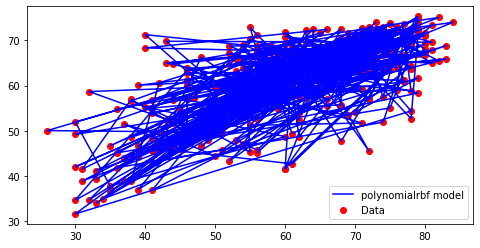

In [38]:
plt.figure(figsize=(8,4))
plt.scatter(Y_train, spotify_poly_train_preds, color='red', label = 'Data')
plt.plot(Y_train, svr_rbf.predict(X_train_prepared), color = 'blue', label= 'polynomialrbf model')
plt.legend()
plt.show()

In [ ]:
# The SVR models that we applied didnt perform as well as the decision tree regression model. It only achieved a score of 11.8673 Kaggle RMSE score. 
# This was becuase it was difficult to imporve the model and tune the hyper parameters based on the lin rmse scores and tables.
# The graph above shows that it was difficult to determine whether the model overfitted or underfitted the data. 